date_Nov 30th, 2016  
author_Claireh(xh895)

In [50]:
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
%pylab inline
import os
import pandas as pd
import geopandas
import zipfile

PUIdata = os.getenv('PUIDATA')
zf = zipfile.ZipFile(PUIdata + '/HW11_data/zbp00totals.zip')

Populating the interactive namespace from numpy and matplotlib


In [51]:
# load geojson file
nyczip_file = '/HW11_data/nyc-zip-code-tabulation-areas-polygons.geojson'
nyczip = geopandas.read_file(PUIdata + nyczip_file)

# extract NYC postalCode
zipcode = pd.DataFrame(int(i) for i in nyczip.postalCode)
zipcode.rename(columns={0: 'ZIP'}, inplace = True)

In [52]:
# load establishment files
year = range(94,100) + range(0,15)
data = zipcode.copy()
for i in year:
    if len(str(i)) == 2:
        # iterate filename
        filename = 'zbp'+ str(i) + 'totals.zip'
        zf = zipfile.ZipFile(PUIdata + '/HW11_data/' + filename)
        df = pd.read_csv(zf.open(filename.replace('.zip','.txt')))
        df.columns = map(str.upper, df.columns)
        df = df[['ZIP','EST']]
        df.rename(columns={'EST': i}, inplace = True)
        data = pd.merge(data, df, how = 'left', on = 'ZIP')
    elif len(str(i)) == 1:
        filename = 'zbp0'+ str(i) + 'totals.zip'
        zf = zipfile.ZipFile(PUIdata + '/HW11_data/' + filename)
        df = pd.read_csv(zf.open(filename.replace('.zip','.txt')))
        df.columns = map(str.upper, df.columns)
        df = df[['ZIP','EST']]
        df.rename(columns={'EST': i}, inplace = True)
        data = pd.merge(data, df, how = 'left', on = 'ZIP')

In [53]:
# drop NAN values
data1 = data.dropna()
# subset data for clustering
est = data1[data1.columns[1:]]
# whitening data
est_T = est.T
est = ((est_T - est_T.mean())/est_T.std()).T

In [54]:
# check if data is standardized
mean_thredshold = ((0-1e-5),(0+1e-5))
std_thredshold = ((1-1e-5),(1+1e-5))

if ((est.mean(axis = 1).all() >= mean_thredshold[0]) & (est.mean(axis = 1).all() <= mean_thredshold[1]) & 
    (est.std(axis = 1).all() >= std_thredshold[0]) & (est.std(axis = 1).all() <= std_thredshold[1])):
    print 'Data is ready to use'
else:
    print 'Data in progress'


Data is ready to use


In [55]:
# perform clustering with KMeans
# n_cluster = 9
kmeans = KMeans(n_clusters=9).fit(est)
# store cluster results in cluster_1
cluster1 = kmeans.labels_
# store center information
centers1 = kmeans.cluster_centers_

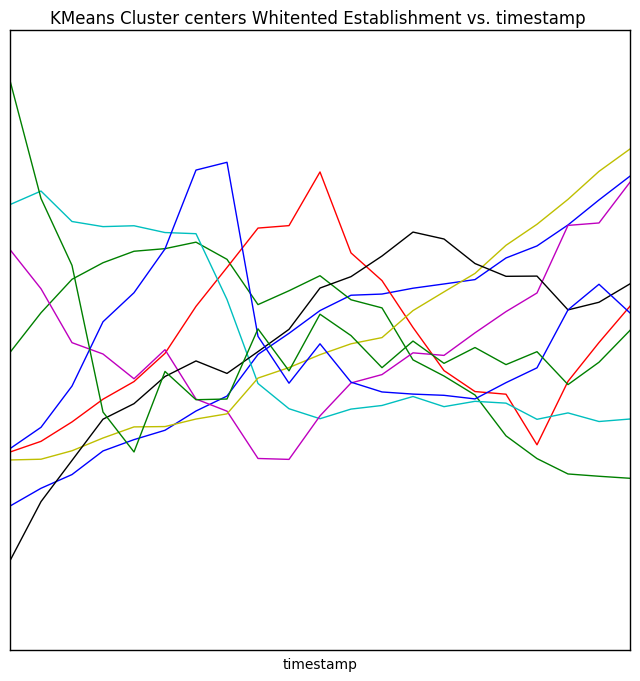

In [56]:
# plot cluster centers
x = range(0,len(year))
plt.figure(figsize = (8,8))
for i in range(0,9):
    plt.plot(x, centers1[i])
plt.yticks([])
plt.xticks([])
plt.ylim(-3,3)
xlabel('timestamp')
plt.title('KMeans Cluster centers Whitented Establishment vs. timestamp ')
plt.legend()

In [57]:
# keep only the zipcode in data1 of nyczip
nyczip1 = nyczip.ix[data1.index, :]

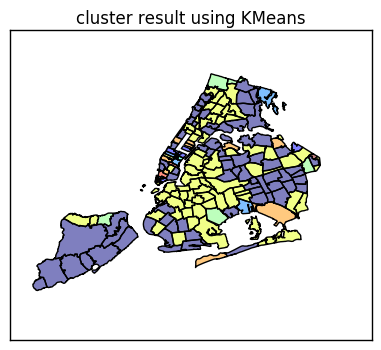

In [58]:
# add cluster result to dataframe
nyczip1['labels1'] = cluster1
# plot cluster 1 result
nyczip1.plot(column = 'labels1')
plt.xticks([])
plt.yticks([])
plt.title('cluster result using KMeans')

In [59]:
# cluster using Agglomerative algorithm
AC = AgglomerativeClustering(n_clusters=9, linkage="ward").fit(est)
# save label results
cluster2 = AC.labels_

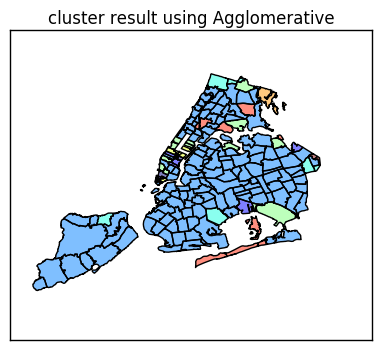

In [60]:
nyczip1['labels2'] = cluster2
nyczip1.plot(column = 'labels2')
plt.xticks([])
plt.yticks([])
plt.title('cluster result using Agglomerative')

From plots above, we can see the clustering results from the two algorithms have some differences, but the pattern is basically the same. Clearly the largest cluster is not so different among the two results, which suggest most zipcodes follow the same change pattern over time.